In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

import os

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    # ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20560102029971303

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [18]:
pd.concat([X_train, X_val], ignore_index = True)

,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,PER,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G
0,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,23.4,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927
1,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,18.6,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963
2,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,17.3,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622
3,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,10.1,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646
4,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,14.3,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23962,9.0,0.0,0.0,0.0,0.0,1.0,0.5,0.5,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-6.6,0.0,0.573,0.024
23963,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-8.8,0.0,0.305,0.012
23964,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-7.5,0.0,0.683,0.024
23965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.050,0.0,0.0,0.0,0.000,-25.9,0.0,0.610,0.024


In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
pipe_scale = Pipeline(steps = [
    ('Scaler', scaler),
    ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
])

In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('Linear Regression Simple')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/2', creation_time=1697481748640, experiment_id='2', last_update_time=1697481748640, lifecycle_stage='active', name='Linear Regression Simple', tags={}>

In [23]:
with mlflow.start_run():
    model = LinearRegression()

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    params = model.get_params()

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

2024/11/01 16:59:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/01 16:59:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-rat-667 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/2/runs/375138324e014c7ba2c7d615cf0318d3.
2024/11/01 16:59:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/2.


In [24]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.114486,0.099494,0.056588
R2,0.471806,0.091044,-0.062104


In [25]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [26]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.340715
LeBron James,2018,0.731,0.417654
Anthony Davis,2018,0.441,0.228675
Damian Lillard,2018,0.205,0.238250
Russell Westbrook,2018,0.075,0.317161
Giannis Antetokounmpo,2018,0.074,0.242222
Kevin Durant,2018,0.065,0.226658
DeMar DeRozan,2018,0.032,0.105200
LaMarcus Aldridge,2018,0.006,0.143239


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.381331
James Harden,2019,0.768,0.429580
Paul George,2019,0.352,0.238706
Nikola Jokić,2019,0.210,0.335263
Stephen Curry,2019,0.173,0.168137
Damian Lillard,2019,0.068,0.244734
Joel Embiid,2019,0.049,0.177013
Kevin Durant,2019,0.025,0.235071
Kawhi Leonard,2019,0.013,0.122623


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.358550
LeBron James,2020,0.746,0.298372
James Harden,2020,0.363,0.294220
Luka Dončić,2020,0.198,0.265101
Kawhi Leonard,2020,0.166,0.161495
Anthony Davis,2020,0.081,0.181247
Chris Paul,2020,0.026,0.074756
Damian Lillard,2020,0.023,0.195420
Nikola Jokić,2020,0.018,0.248928


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.437706
Joel Embiid,2021,0.580,0.120980
Stephen Curry,2021,0.449,0.212084
Giannis Antetokounmpo,2021,0.345,0.263534
Chris Paul,2021,0.138,0.105214
Luka Dončić,2021,0.042,0.253611
Damian Lillard,2021,0.038,0.169137
Julius Randle,2021,0.020,0.173013
Derrick Rose,2021,0.010,0.025476


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.510774
Joel Embiid,2022,0.706,0.276322
Giannis Antetokounmpo,2022,0.595,0.356392
Devin Booker,2022,0.216,0.122308
Luka Dončić,2022,0.146,0.287193
Jayson Tatum,2022,0.043,0.209495
Ja Morant,2022,0.010,0.160100
Stephen Curry,2022,0.004,0.152600
Chris Paul,2022,0.002,0.095019


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.280698
Nikola Jokić,2023,0.674,0.436853
Giannis Antetokounmpo,2023,0.606,0.299867
Jayson Tatum,2023,0.280,0.201762
Shai Gilgeous-Alexander,2023,0.046,0.187152
Donovan Mitchell,2023,0.030,0.165634
Domantas Sabonis,2023,0.027,0.287770
Luka Dončić,2023,0.010,0.287577
Stephen Curry,2023,0.005,0.171044


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.556804
Shai Gilgeous-Alexander,2024,0.646,0.282074
Luka Dončić,2024,0.572,0.384457
Giannis Antetokounmpo,2024,0.194,0.381234
Jalen Brunson,2024,0.143,0.245365
Jayson Tatum,2024,0.087,0.196134
Anthony Edwards,2024,0.018,0.138169
Domantas Sabonis,2024,0.003,0.346840
Kevin Durant,2024,0.001,0.185529


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.018686
Steven Adams,2018,0.0,0.026869
Bam Adebayo,2018,0.0,0.008159
Arron Afflalo,2018,0.0,0.017818
Cole Aldrich,2018,0.0,0.039028
...,...,...,...
Danny Green,2024,0.0,0.001344
Ron Harper Jr.,2024,0.0,0.041214
Justin Jackson,2024,0.0,0.051466


In [27]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
DeMarcus Cousins,2018,0.0,0.118771
Andre Drummond,2018,0.0,0.130036
Al Horford,2018,0.0,0.135088
Kyrie Irving,2018,0.0,0.145119
Nikola Jokić,2018,0.0,0.241892
...,...,...,...
Tyrese Haliburton,2024,0.0,0.177069
James Harden,2024,0.0,0.100618
Jarrett Allen,2024,0.0,0.125321


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

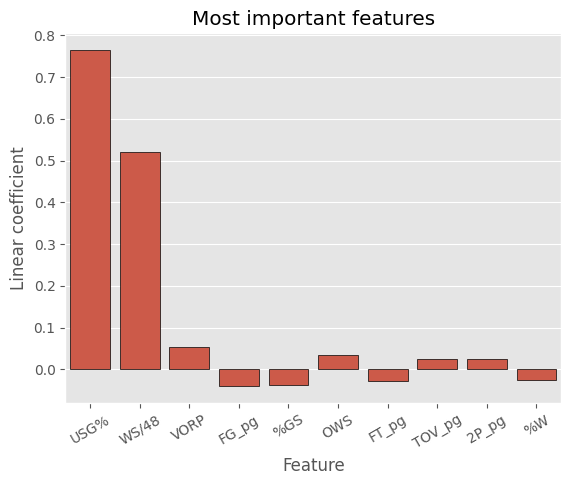

In [28]:
mod.display_linear_coef(model)

In [29]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

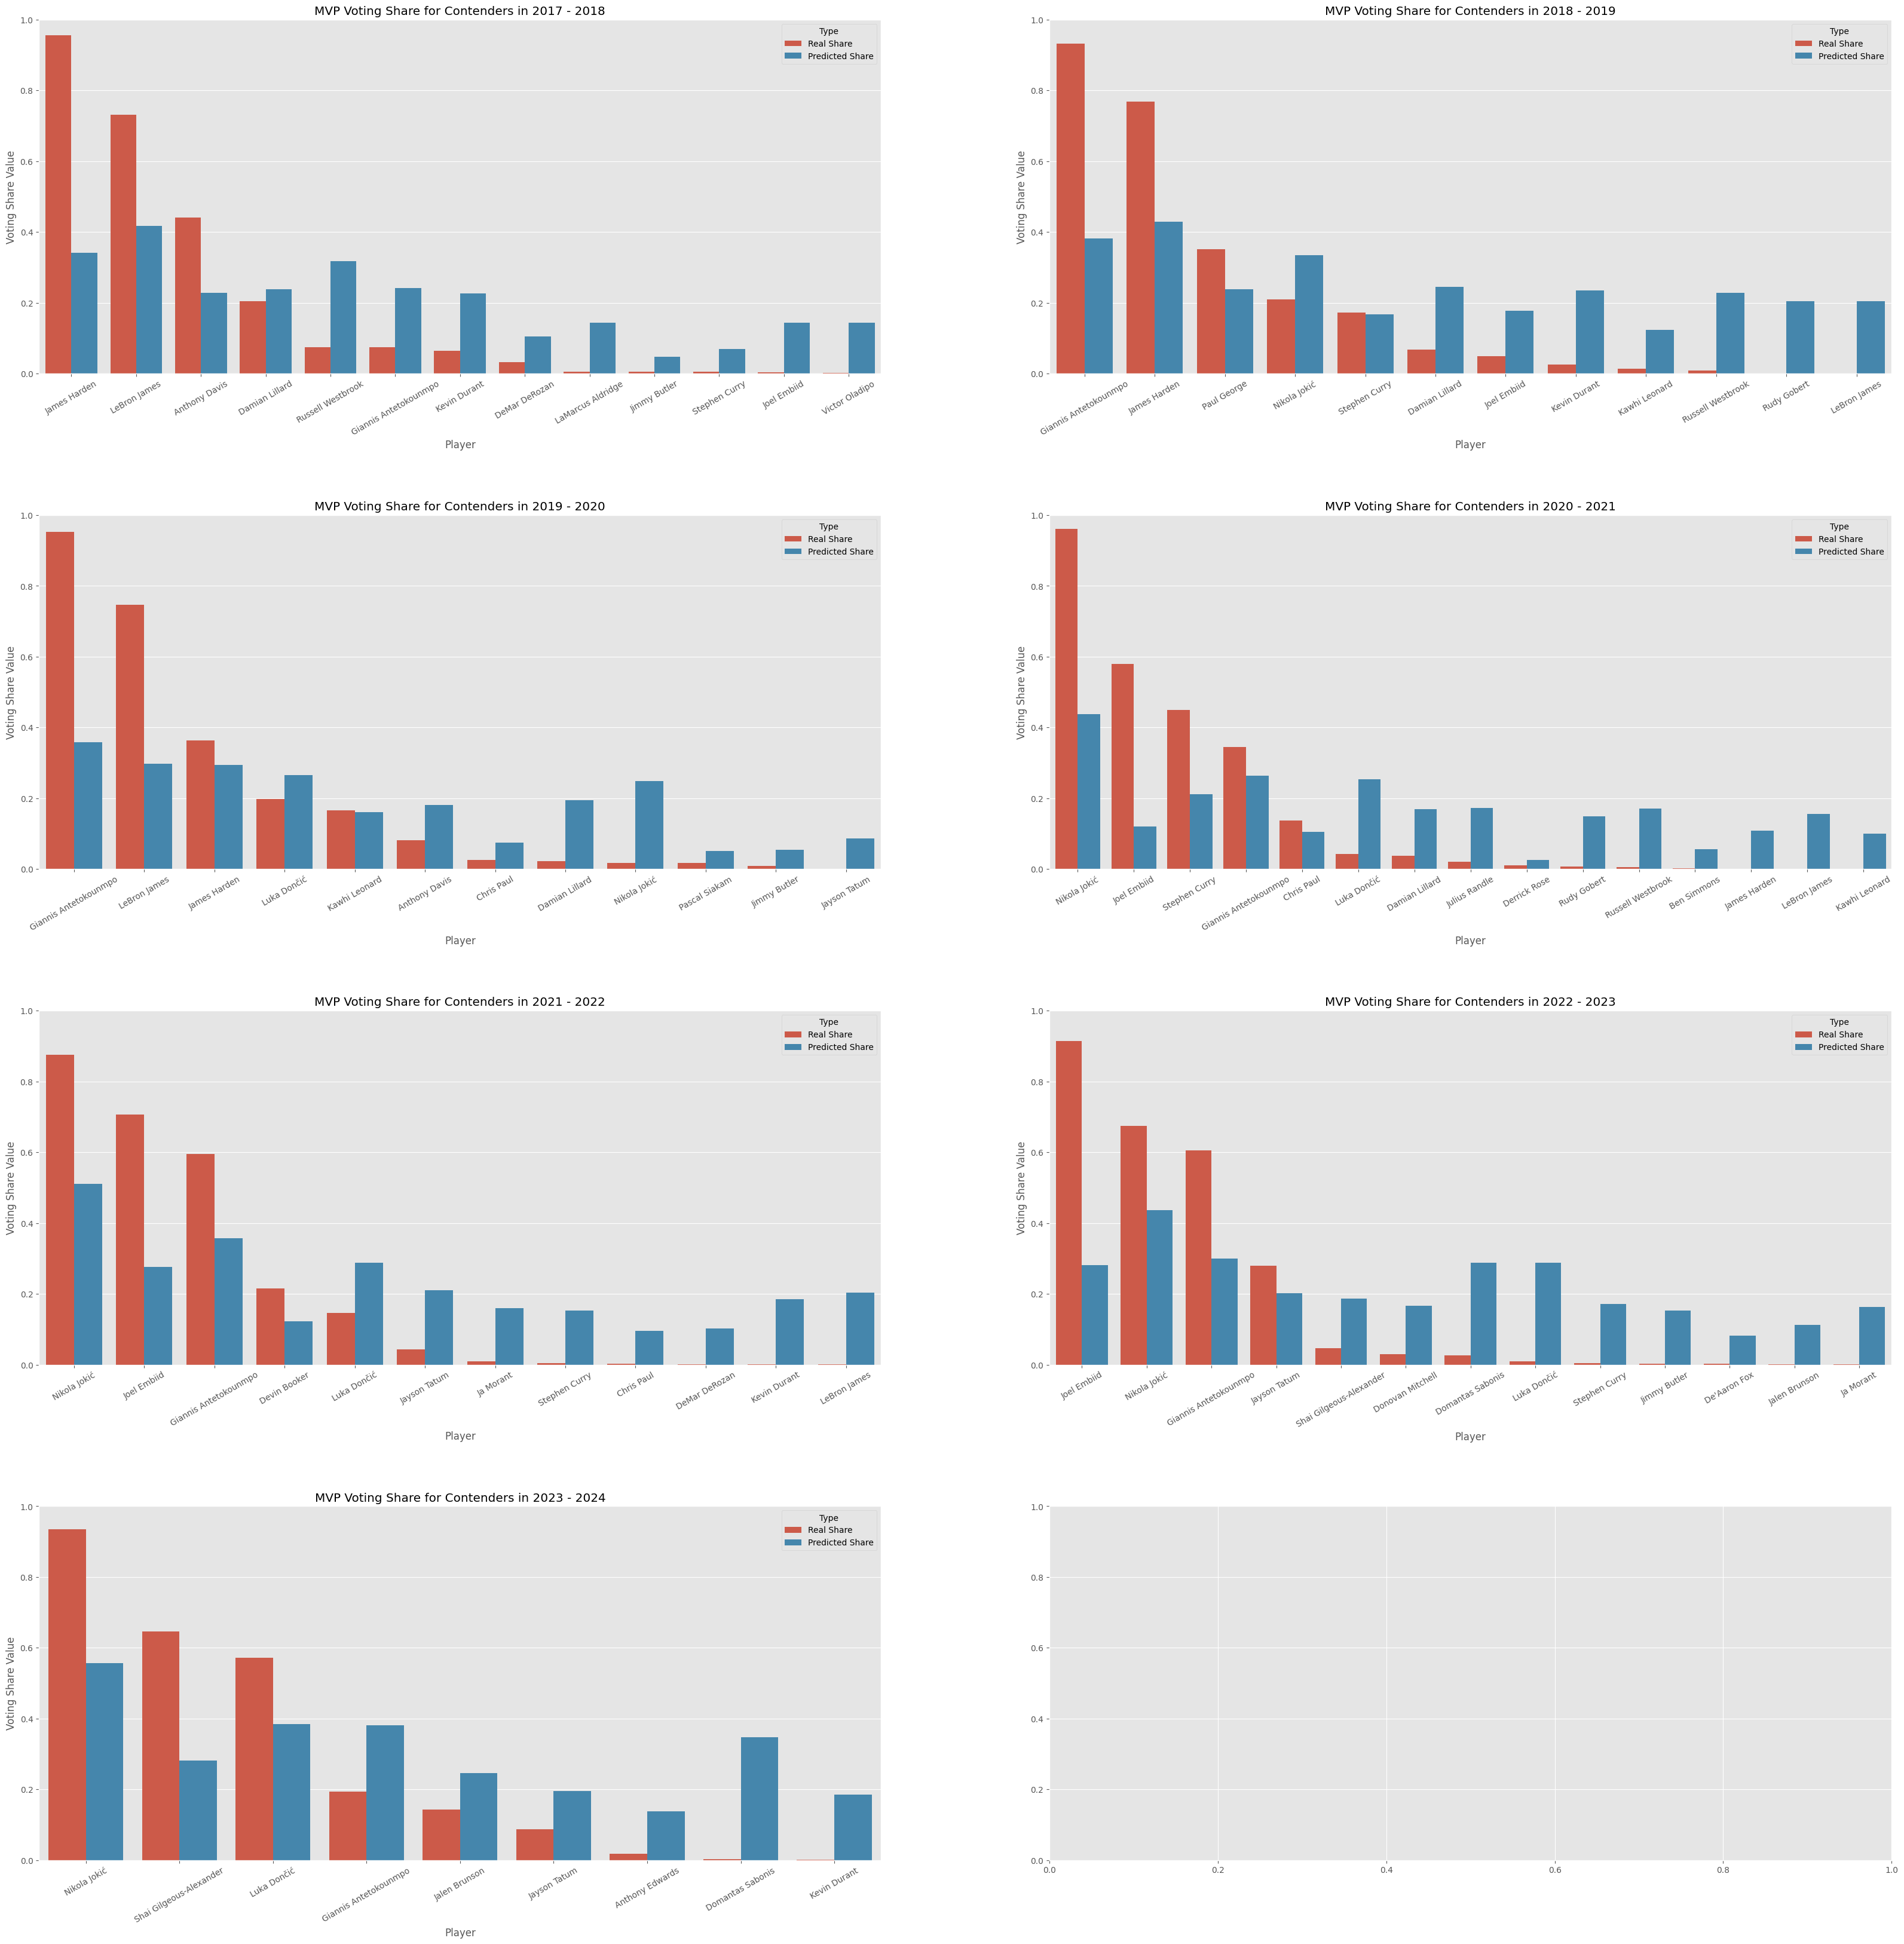

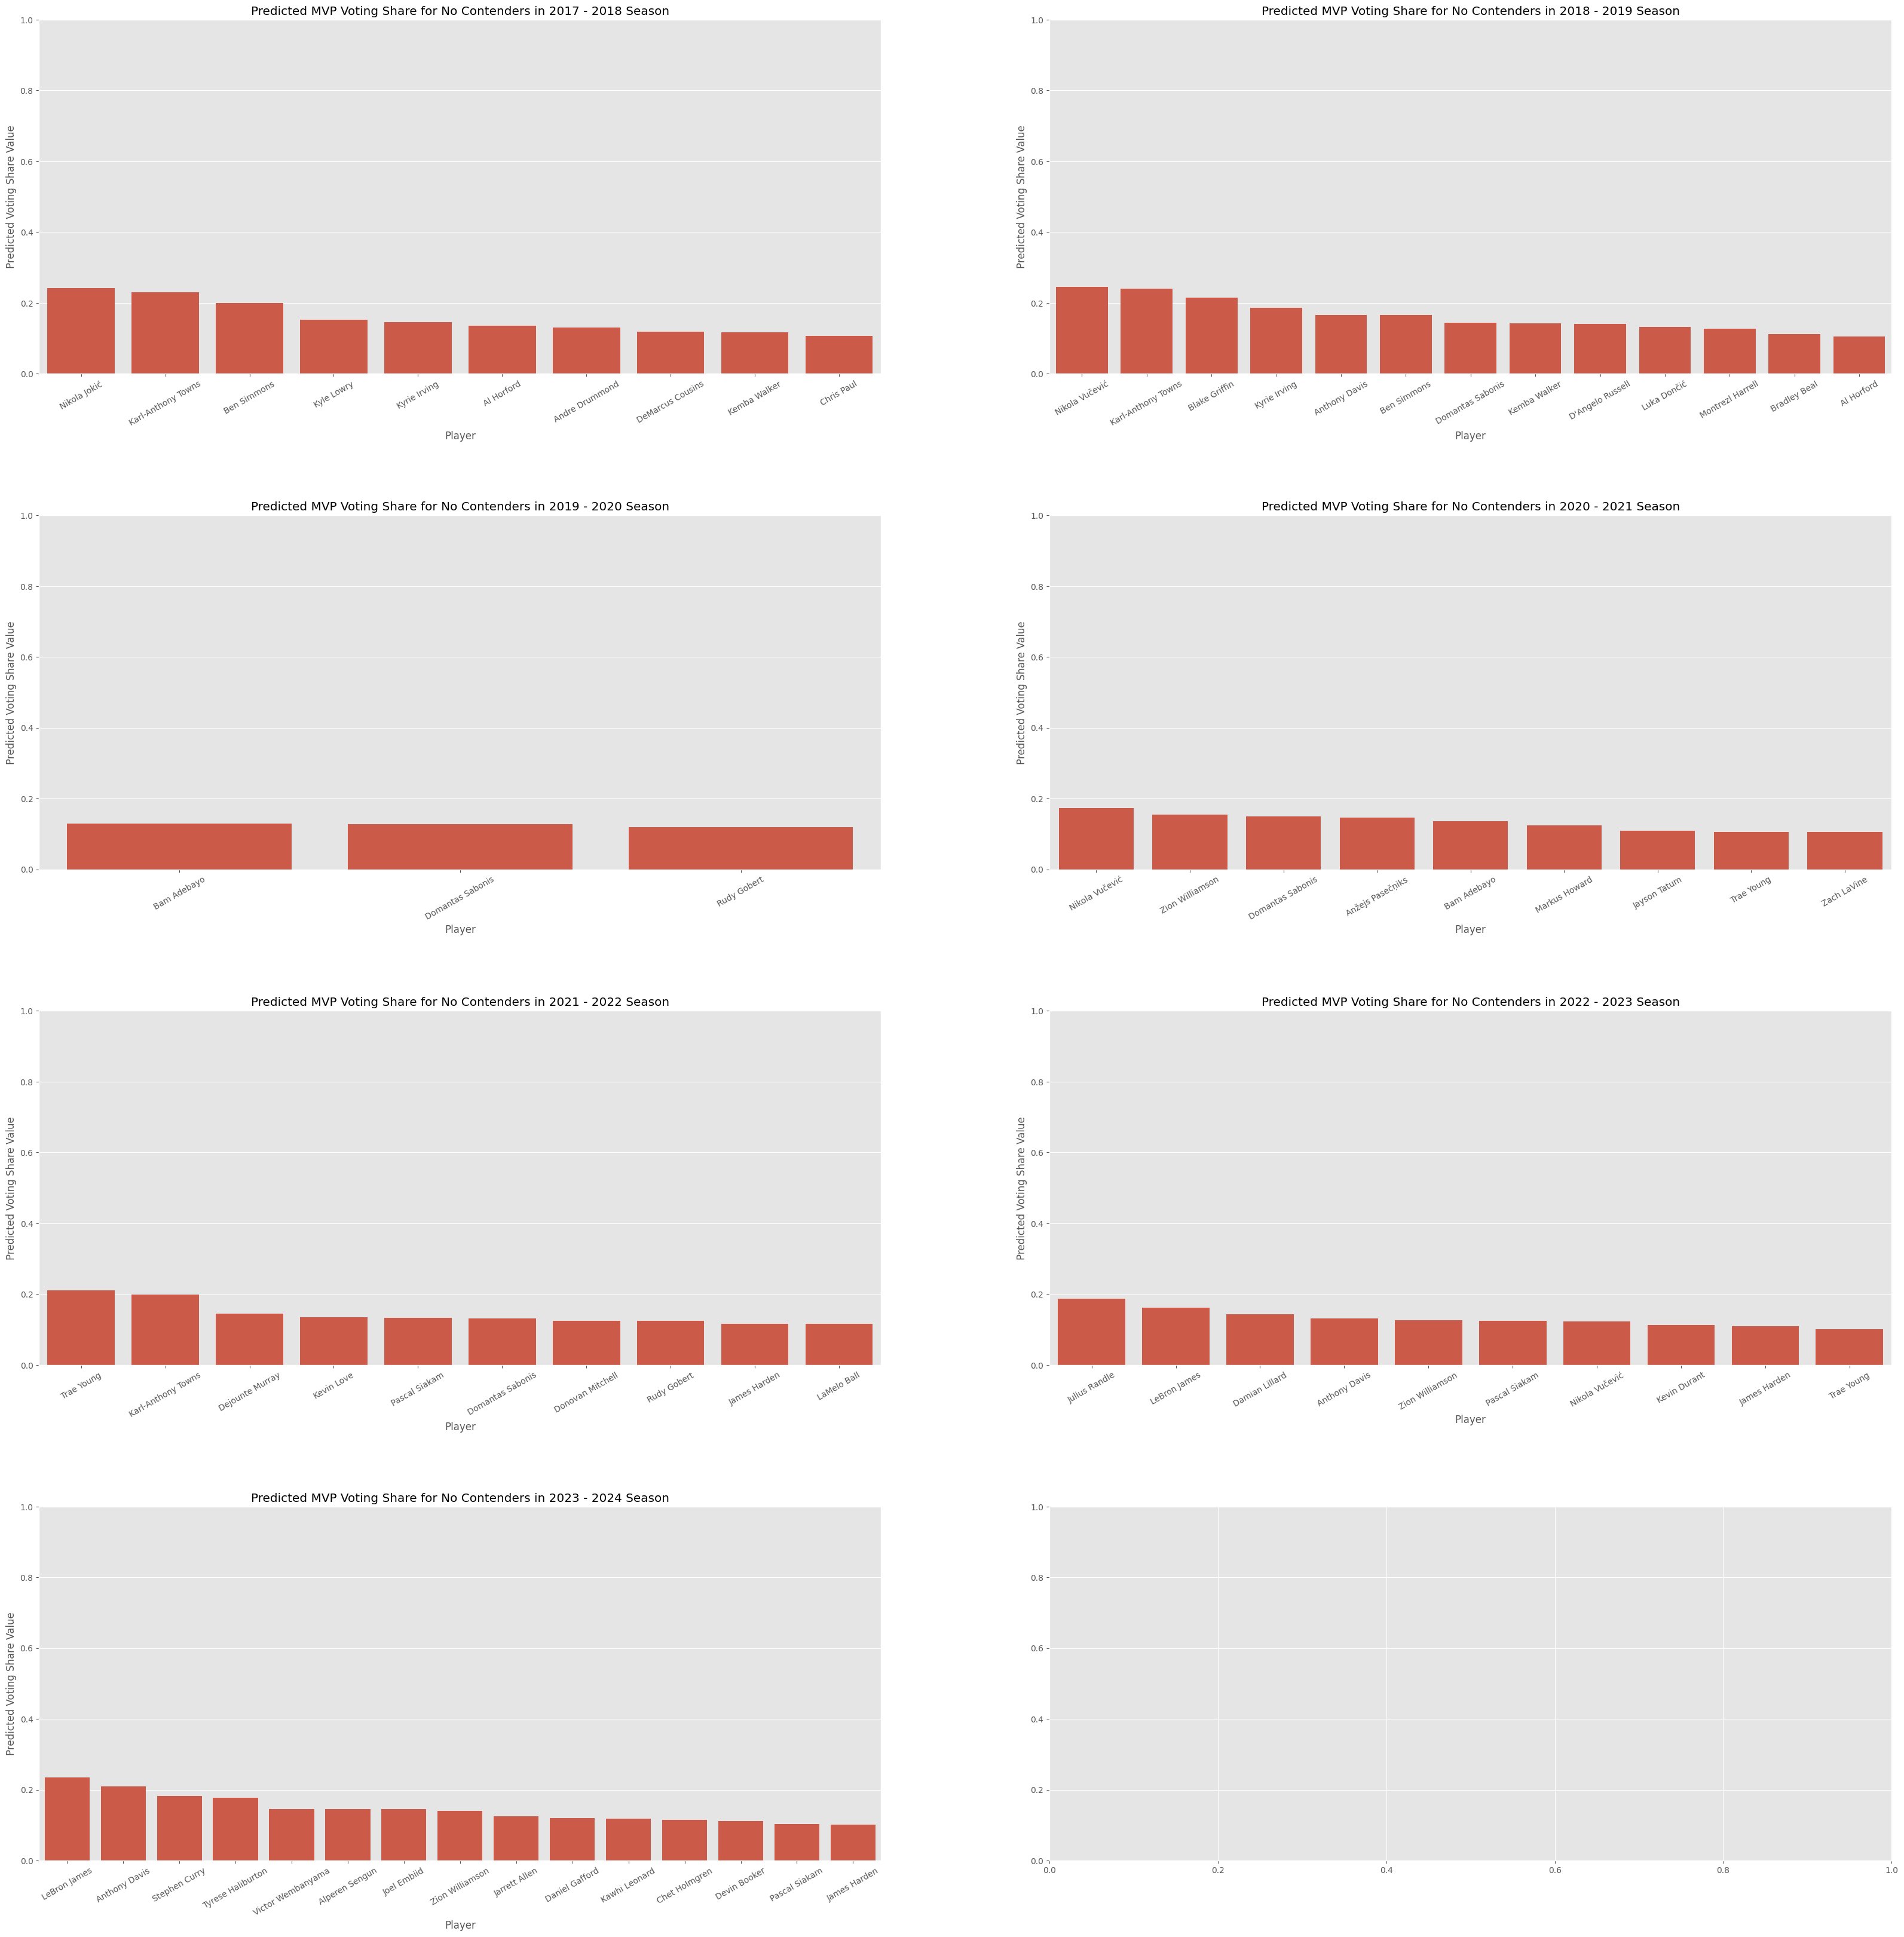

In [30]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])

In [31]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [32]:
# top_features[top_features['Importance'] > 0.005]